# Plant Pathology 2020 - FGVC7 with Fastai
> Identify apple leaves into four categories: healthy, scab, rust, multiple diseases
- toc: false
- branch: master
- badges: true
- comments: true
- categories: [fastpages, jupyter]
- image: images/some_folder/your_image.png

## 1) Import libraries, setup file paths, define helper functions

In [202]:
#collapse-hide
from fastai2.vision.all import *
from fastai2.vision.widgets import *

from IPython.display import clear_output
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

%matplotlib inline

In [203]:
#collapse-hide
path = Path(); path
test_dir = path/'data/test'

In [204]:
#collapse-hide
def get_idx_df_val(df, cols, n_samp):
    
    idx_list = []

    for col in cols:
        idx = df.index[df[col] == 1]
        idx_samp = np.random.permutation(idx)[:n_samp].tolist()
        idx_list = idx_list + idx_samp
    return idx_list

def stratify_df_indices(df, n_samp, use_min=True):
    new_df = pd.DataFrame(columns=df.columns)
    temp_df = df[df.is_valid != 1].drop(columns=['image_id', 'is_valid'])
    
    for col in df.columns[1:-1]:
        if use_min:
            n = min(n_samp, temp_df.sum().min())
        else:
            n = min(n_samp, temp_df[col].sum())
            
        #print(n)
        new_df = pd.concat([new_df, df[(df[col] == 1) & (df['is_valid'] != 1)].sample(n)])
        
    return list(new_df.index)

def comp_metric(preds, targs, labels=range(4)):
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_auc(*args):
    return comp_metric(*args, labels=[0])

def mult_diseases_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_auc(*args):
    return comp_metric(*args, labels=[3])

## 2a) Import and explore the data

In [205]:
df = pd.read_csv(path/'train.csv')
print('Dataframe shape:', df.shape)
df.head()

Dataframe shape: (1821, 5)


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


### Example Leafs
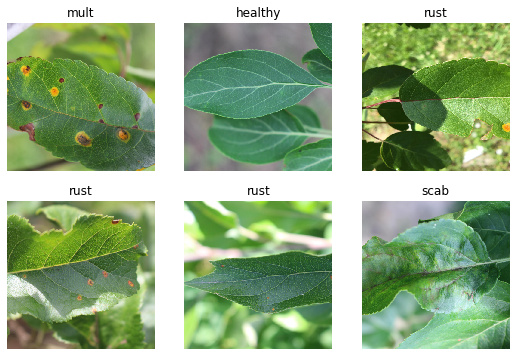

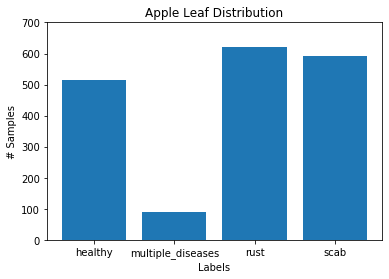

healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


In [206]:
#collapse-hide
labels = df.columns[1:];
plt.bar(labels,df[labels].sum())
plt.xlabel('Labels')
plt.ylabel('# Samples')
plt.title('Apple Leaf Distribution')
plt.ylim(0,700)
plt.show()
print(df[labels].sum())

## 2b) Select # of samples for training and validation datasets
- num_val = 30 (for each category)
- num_train = max amount available for training

In [207]:
#collapse-hide
# number of samples for validation
num_val = 30
# number of samples for training
num_train = df[labels].sum().max()

# Before oversampling, create is_valid category, and split into train/val
# Adding another pd.read_csv just for ease of debugging here
df = pd.read_csv(path/'train.csv')
idx_val = get_idx_df_val(df, df.columns[1:], num_val)
vec_val = np.zeros(len(df), dtype=bool)
vec_val[idx_val] = True
df['is_valid'] = vec_val
idx_train = stratify_df_indices(df, num_train, False)
idx_all = idx_val + idx_train
df = df.iloc[idx_all]
df = df.rename(columns={"multiple_diseases": 'mult'})
df.sample(5)
#df.head()

,image_id,healthy,mult,rust,scab,is_valid
966,Train_966,1,0,0,0,False
1701,Train_1701,0,0,0,1,False
1432,Train_1432,1,0,0,0,False
68,Train_68,1,0,0,0,False
1670,Train_1670,1,0,0,0,False


In [208]:
#collapse-hide
# find worst ratio, do floor of that number.
# sum category columns, sort, find min1 and min2
_, min1, min2 = np.sort(df.drop(columns=['image_id'])[df.is_valid == 0].sum().values)[:3]

oversamp = int(min2/min1)-1

df_mult = df[(df.mult==1) & (df.is_valid == 0)]
for i in range(oversamp):
    df = pd.concat([df, df_mult])

df = df.sample(frac=1, random_state=42)
df_os = df.copy()

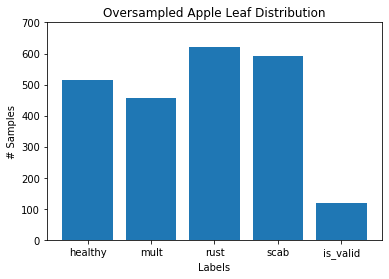

healthy     516.0
mult        457.0
rust        622.0
scab        592.0
is_valid    120.0
dtype: float64


In [209]:
#collapse-hide
labels = df.columns[1:];
plt.bar(labels,df[labels].sum())
plt.xlabel('Labels')
plt.ylabel('# Samples')
plt.title('Oversampled Apple Leaf Distribution')
plt.ylim(0,700)
plt.show()
print(df[labels].sum())

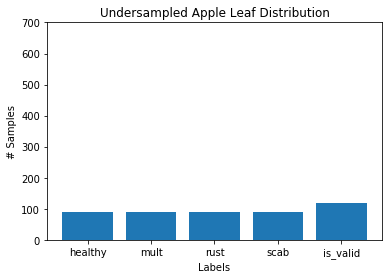

healthy      90.0
mult         90.0
rust         90.0
scab         90.0
is_valid    120.0
dtype: float64


In [210]:
#collapse-hide

# ***Repeat of code above to show undersampling

# number of samples for validation
num_val = 30
# number of samples for training
num_train = 60

# Before oversampling, create is_valid category, and split into train/val
# Adding another pd.read_csv just for ease of debugging here
df = pd.read_csv(path/'train.csv')
idx_val = get_idx_df_val(df, df.columns[1:], num_val)
vec_val = np.zeros(len(df), dtype=bool)
vec_val[idx_val] = True
df['is_valid'] = vec_val
idx_train = stratify_df_indices(df, num_train, False)
idx_all = idx_val + idx_train
df = df.iloc[idx_all]
df = df.rename(columns={"multiple_diseases": 'mult'})
df.sample(5)
#df.head()

# find worst ratio, do floor of that number.
# sum category columns, sort, find min1 and min2
_, min1, min2 = np.sort(df.drop(columns=['image_id'])[df.is_valid == 0].sum().values)[:3]

oversamp = int(min2/min1)-1

df_mult = df[(df.mult==1) & (df.is_valid == 0)]
for i in range(oversamp):
    df = pd.concat([df, df_mult])

df = df.sample(frac=1, random_state=42)

labels = df.columns[1:];
plt.bar(labels,df[labels].sum())
plt.xlabel('Labels')
plt.ylabel('# Samples')
plt.title('Undersampled Apple Leaf Distribution')
plt.ylim(0,700)
plt.show()
print(df[labels].sum())

### How to address class imbalance?
- Insights from 2017 paper, "A systematic study of the class imbalance problem in convolutional neural networks", by Buda et al.
- Tried common imbalance techniques: oversample, undersample, decision thresholding, two-phase training
- Did most experiments in MNIST + CIFAR10, and a few on ImageNet
- Used simpler models: LeNet-5, All-CNN, ResNet-10

### Key insights
1. Class imbalance on classification performance is detrimental
2. Oversampling was the dominant choice
3. Oversample until the class imbalance is gone (sometimes >50x)
4. Oversampling does not cause overfitting of CNNs
5. Thresholding works with oversampling, and can sometimes help

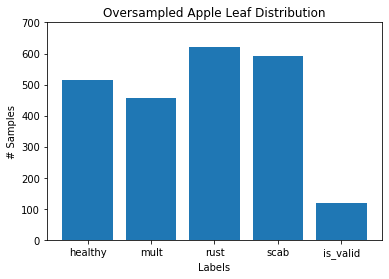

In [215]:
#collapse-hide
df=df_os
plt.bar(labels,df[labels].sum())
plt.xlabel('Labels')
plt.ylabel('# Samples')
plt.title('Oversampled Apple Leaf Distribution')
plt.ylim(0,700)
plt.show()